# 1. Library import

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import time
import numpy as np
import gc
import sys
import pickle
import copy
import pandas as pd
#from AttentiveLayers_MLP import *
from AttentiveLayers_Viz import *
from Featurizer import *
from getFeatures import *

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from rdkit import Chem
from rdkit.Chem import QED
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns
sns.set(color_codes = True)

In [2]:
import os
os.getcwd()

'/home/dohyeon/hERGAT'

In [3]:
import os
os.chdir('/home/dohyeon/hERGAT/dataset')

# 2.dataset and preprocessing

## Delete the duplicated data standard on Canonical smiles

In [4]:
task_name = 'Class'
tasks = ['Class']
raw_filename = "hERG dataset.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.SMILES.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["SMILES"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)
smiles_tasks_df.head()

number of all smiles:  7933
number of successfully processed smiles:  7933


,Unnamed: 0,SMILES,pIC50,hERG,Class,cano_smiles
0,0,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...,9.85,0.979,1,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@H](Oc2cccc(C(N)=O...
1,1,COc1nc2ccc(Br)cc2cc1[C@@H](c3ccccc3)[C@@](O)(C...,9.70,0.994,1,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...
2,2,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCCc...,9.60,0.986,1,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCCc...
3,3,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@@H](C3)Oc4cccc(c4...,9.59,0.949,1,Cc1ccc(CN2[C@@H]3CC[C@H]2C[C@H](Oc2cccc(C(N)=O...
4,4,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCc4...,9.42,0.983,1,NC(=O)c1cccc(O[C@@H]2C[C@H]3CC[C@@H](C2)N3CCc2...


In [5]:
random_seed =100
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()
radius = 3
T = 2
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num # 2 

In [6]:
len(smiles_tasks_df)

7933

In [40]:
# Use the length of SMILES less than 100
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]

uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

# delete the duplicated cano_smiles in uncovered
smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

feature_dicts = get_smiles_dicts(smilesList)
# keys = smiles values in cano_smiles값
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())] 
uncovered_df = smiles_tasks_df.drop(remained_df.index) 
uncovered_df # 최종적으로 uncovered_df에는 get_smiles_dicts로 바꾼 값과 cano_smiles와 비교하였을 때 삭제

Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3ccc(S(F)(F)(F)(F)F)cc3)C2)n1C
Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3cccc(S(F)(F)(F)(F)F)c3)C2)n1C
[Cl-]


,Unnamed: 0,SMILES,pIC50,hERG,Class,cano_smiles
1240,1240,Cc1ncoc1c2nnc(SCCCN3CC4CC4(C3)c5ccc(cc5)S(F)(F...,6.1,0.954,1,Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3ccc(S(F)(F)(F)(F...
1671,1671,Cc1ncoc1c2nnc(SCCCN3CC4CC4(C3)c5cccc(c5)S(F)(F...,5.9,0.950,1,Cc1ncoc1-c1nnc(SCCCN2CC3CC3(c3cccc(S(F)(F)(F)(...
3704,3704,[Cl-],5.2,0.972,1,[Cl-]


Remain 7,930 dataset...
duplicated 3 cano_smiles are deleted|

## Physicochemical properties 생성

In [9]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors

Reset index in remained_df to initialize the index for later concatenation

In [10]:
remained_df = remained_df.reset_index()

In [11]:
# mol 형태로 변환
train_mols = [Chem.MolFromSmiles(smiles) for smiles in remained_df["cano_smiles"]]

# mol 형태로 변환이 되지 않은 경우, none_list에 담는다
none_list = []
for i in range(len(train_mols)):
    if train_mols[i] is None :
        none_list.append(i)
        print('none_list에 추가됨')
    
reg_idx = 0
for i in none_list :
    del train_mols[i - reg_idx]
    reg_idx += 1
    
# none_list가 존재할 경우, 삭제 후 데이터프레임 인덱스 맞춰주기
if len(none_list) != 0 :
    remained_df = remained_df.drop(none_list, axis=0)
    remained_df = remained_df.reset_index(drop = True)


In [12]:
# fingerprint 생성
bit_info_list = [] # bit vector의 설명자 리스트 담기
bit_info = {} #bit vector 설명자
fps = []

b = 0
# mol 파일에서 fingerprint Bit Vector 형태로 변환하기
for a in train_mols :
    fps.append(AllChem.GetMorganFingerprintAsBitVect(a, 3, nBits = 1024, bitInfo = bit_info))
    bit_info_list.append(bit_info.copy()) # bit_info 그대로 가져오면 변수가 변해서 리스트 값이 달라지므로 .copy()
    
# array 변환

arr_list = []
for i in range(len(fps)):
    array = np.zeros((0,), dtype = np.int8)
    arr_list.append(array)
for i in range(len(fps)):
    bit = fps[i]
    DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    
train_x = np.stack([i.tolist() for i in arr_list])
train_finprt = pd.DataFrame(train_x)
train_finprt.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
import joblib
from sklearn.preprocessing import StandardScaler

# StandardScaler

sds_scaler = StandardScaler()

# molecular physicochemical properties 구하기

from rdkit.Chem import QED

train_qe = [QED.properties(mol) for mol in train_mols]
train_qe = pd.DataFrame(train_qe)
train_qe = train_qe.drop(columns = ['ROTB', 'AROM', 'ALERTS'])
train_qe[['MW', 'ALOGP', 'HBA', 'HBD', 'PSA']] = sds_scaler.fit_transform(train_qe[['MW', 'ALOGP', 'HBA', 'HBD', 'PSA']])
input_df=pd.concat([train_finprt, train_qe], axis=1)
new_remained_df = pd.concat([remained_df, input_df], axis = 1)
new_remained_df = new_remained_df.drop(columns = ['index', 'pIC50', 'hERG', 'Unnamed: 0'])
new_remained_df

,MW,ALOGP,HBA,HBD,PSA
0,-0.917145,-0.177788,-0.905935,-0.240880,-0.502855
1,1.267313,2.290658,-0.412761,-0.240880,-0.812253
2,-0.767714,-0.089251,-0.905935,-0.240880,-0.502855
3,-0.852917,-0.133940,-0.905935,-0.240880,-0.502855
4,-0.917145,-0.367382,-0.905935,-0.240880,-0.502855
...,...,...,...,...,...
7925,1.160303,-0.326243,0.573587,2.519498,1.530423
7926,1.181779,-0.166537,0.573587,2.519498,1.530423
7927,1.309733,-0.048112,0.573587,2.519498,1.530423
7928,1.331210,0.111594,0.573587,2.519498,1.530423


In [16]:
for key, value in feature_dicts.items():
    print(key)

smiles_to_atom_mask
smiles_to_atom_info
smiles_to_bond_info
smiles_to_atom_neighbors
smiles_to_bond_neighbors
smiles_to_rdkit_list


가중치는 전체 샘플수에서 해당 클래스의 샘플 수로 결정 - 소수 클래스에 더 높은 가중치 부여

 => nn.CrossEntropyLoss와 같이 가중치를 사용하면 클래스 불균형 문제 해결
  - 소수 클래스의 손실이 전체 손실에 더 영향을 주게 되어 모델이 소수 클래스에도 더 예측할수 있도록 학습하게 하는 효과

In [17]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = new_remained_df[new_remained_df[task] == 0][["SMILES",task]] # 
    positive_df = new_remained_df[new_remained_df[task] == 1][["SMILES",task]] # 
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
# weights = [[2.862815884476534, 1.5368217054263567]]


# train/test/valid split
test_df = new_remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = new_remained_df.drop(test_df.index) # training data
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [18]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(6344, 1032)
(793, 1032)
(793, 1032)


In [19]:
print('train_df label의 shape')
print(train_df['Class'].value_counts())
print('test_df label의 shape')
print(test_df['Class'].value_counts())
print('valid_df label의 shape')
print(valid_df['Class'].value_counts())

train_df label의 shape
1    4102
0    2242
Name: Class, dtype: int64
test_df label의 shape
1    537
0    256
Name: Class, dtype: int64
valid_df label의 shape
1    521
0    272
Name: Class, dtype: int64


데이터준비완료

### GNN 사용하기 위해 데이터준비

In [20]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]], feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = [nn.CrossEntropyLoss(weight=torch.Tensor(weight), reduction='mean') for weight in weights]

# loss_function = [nn.BCEWithLogitsLoss(pos_weight = pos_weight, weight=torch.Tensor(weight), reduction='mean') for weight in weights]

### model ExtendedFingerprint 선언

In [21]:
################################
# bayesian optimizer로 찾은 최적의 parameter 값 #
physicochemical_feature_dim = 1029
batch_size = 114
p_dropout = 0.475
fingerprint_dim = 100
learning_rate = 4.629
weight_decay = 2.291
radius = 3
T = 2
################################


model = ExtendedFingerprint_viz(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout, physicochemical_feature_dim)

optimizer = optim.Adam(model.parameters(), lr = 10**-learning_rate, weight_decay = 10**-weight_decay)

model_parameters = filter(lambda p : p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

651572


In [22]:
for name, param in model.named_parameters():
    print(name, param.data.shape)

atom_fc.weight torch.Size([100, 39])
atom_fc.bias torch.Size([100])
neighbor_fc.weight torch.Size([100, 49])
neighbor_fc.bias torch.Size([100])
GRUCell.0.weight_ih torch.Size([300, 100])
GRUCell.0.weight_hh torch.Size([300, 100])
GRUCell.0.bias_ih torch.Size([300])
GRUCell.0.bias_hh torch.Size([300])
GRUCell.1.weight_ih torch.Size([300, 100])
GRUCell.1.weight_hh torch.Size([300, 100])
GRUCell.1.bias_ih torch.Size([300])
GRUCell.1.bias_hh torch.Size([300])
GRUCell.2.weight_ih torch.Size([300, 100])
GRUCell.2.weight_hh torch.Size([300, 100])
GRUCell.2.bias_ih torch.Size([300])
GRUCell.2.bias_hh torch.Size([300])
align.0.weight torch.Size([1, 200])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 200])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 200])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([100, 100])
attend.0.bias torch.Size([100])
attend.1.weight torch.Size([100, 100])
attend.1.bias torch.Size([100])
attend.2.weight torch.Size([100, 100])
attend

In [23]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(30)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)    
        
        selected_rows = batch_df[batch_df['cano_smiles'] == smiles_list].drop(columns=['SMILES', 'Class', 'cano_smiles'])
        physicochemical_features= torch.tensor(selected_rows.to_numpy(dtype=np.float32), dtype=torch.float)

        atoms_prediction, atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model(torch.Tensor(x_atom).cpu(),torch.Tensor(x_bonds).cpu(),torch.LongTensor(x_atom_index).cpu(),torch.LongTensor(x_bond_index).cpu(),torch.Tensor(x_mask).cpu(), physicochemical_features.cpu())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
        
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []

    
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        selected_rows = batch_df[batch_df['cano_smiles'] == smiles_list].drop(columns=['SMILES', 'Class', 'cano_smiles'])
        physicochemical_features= torch.tensor(selected_rows.to_numpy(dtype=np.float32), dtype=torch.float)
#        physicochemical_features = physicochemical_features.expand(batch_size, -1)
        
        atoms_prediction, atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model(torch.Tensor(x_atom).cpu(),torch.Tensor(x_bonds).cpu(),torch.LongTensor(x_atom_index).cpu(),torch.LongTensor(x_bond_index).cpu(),torch.Tensor(x_mask).cpu(), physicochemical_features.cpu())

        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]

            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss = loss_function[i](
                y_pred_adjust,
                torch.LongTensor(y_val_adjust))
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.numpy()[:,1]
            losses_list.append(loss.detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    # 시행할때마다 모델에서 최적의 optimal_threshold값을 찾아 성능평가
    
    def find_optimal_threshold(precision, recall, thresholds):
        f1_scores = 2*((precision*recall)/(precision+recall))
        index = np.argmax(f1_scores)
        return thresholds[index]

    test_prc = []
    test_thresholds = []
    optimal_thresholds = []
    for i in range(len(tasks)):
        precision, recall, thresholds = precision_recall_curve(y_val_list[i], y_pred_list[i])
        optimal_threshold = find_optimal_threshold(precision, recall, thresholds)
        optimal_thresholds.append(optimal_threshold)
        test_prc.append(auc(recall, precision))
        test_thresholds.append(thresholds)
        
        
    test_precision = [precision_score(y_val_list[i], (np.array(y_pred_list[i]) > optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],(np.array(y_pred_list[i]) >optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    test_f1_score = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(test_precision, test_recall)]    
    conf_matrices = [confusion_matrix(y_val_list[i], (np.array(y_pred_list[i]) > optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    test_sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in conf_matrices]
    test_specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in conf_matrices]
    test_acc = [accuracy_score(y_val_list[i], (np.array(y_pred_list[i]) > optimal_thresholds[i]).astype(int)) for i in range(len(tasks))]
    fpr_list, tpr_list, thresholds2 = [], [], []
    for i in range(len(tasks)):
        fpr, tpr, thresholds = roc_curve(y_val_list[i], y_pred_list[i])
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_acc, test_roc, test_prc, test_precision, test_recall, test_f1_score, test_loss, test_sensitivity, test_specificity, fpr_list, tpr_list, optimal_thresholds

In [24]:
best_param = {"roc_epoch": 0, "valid_roc": 0, "loss_epoch": 0, "valid_loss": float('inf')}
best_param

{'roc_epoch': 0, 'valid_roc': 0, 'loss_epoch': 0, 'valid_loss': inf}

### Earlystopping

In [25]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.counter = 0
        self.patience = patience
        self.early_stop = False

    def step(self, loss):
        if loss < self.loss:
            self.loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def should_step(self):
        return self.early_stop
    
early_stopping = EarlyStopping(patience = 15)    

## Model training

In [ ]:
import os
os.chdir('/home/dohyeon/hERGAT')

epochs = 300
train_loss_vis2 = []
valid_loss_vis2 = []
train_roc2 = []
valid_roc2 = []
train_sensitivity2 = []
train_specificity2 = []
valid_precision2 = []
valid_recall2 = []
valid_optimal_thresholds2=[]

for epoch in range(epochs):    
    start_time = time.time() # epoch의 시작시간
    
    train(model, train_df, optimizer, loss_function)
  
    
    train_acc, train_roc, train_prc, train_precision, train_recall, train_f1_score, train_loss, train_sensitivity, train_specificity, train_fpr, train_tpr, train_optimal_thresholds= eval(model, train_df)
    valid_acc, valid_roc, valid_prc, valid_precision, valid_recall, valid_f1_score, valid_loss, valid_sensitivity, valid_specificity, valid_fpr, valid_tpr, valid_optimal_thresholds= eval(model, valid_df)
    train_roc_mean = np.array(train_roc2).mean()
    valid_roc_mean = np.array(valid_roc2).mean()
    train_loss_vis2.append(train_loss)
    valid_loss_vis2.append(valid_loss)
    train_roc2.append(train_roc)
    valid_roc2.append(valid_roc)
    train_sensitivity2.append(train_sensitivity)
    train_specificity2.append(train_specificity)
    valid_precision2.append(valid_precision)
    valid_recall2.append(valid_recall)
    valid_optimal_thresholds2.append(valid_optimal_thresholds)
    
    
    

        
    if valid_roc_mean > 0.60:
             torch.save(model, 'saved_model/model_'+prefix_filename+'_'+str(epoch)+'.pt')                
            
    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
                
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_acc"+":"+str(train_acc)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_precision"+":"+str(train_precision)+'\n'
        +"train_recall"+":"+str(train_recall)+'\n'
        +"train_specificity"+":"+str(train_specificity)+'\n'\
        +"train_f1_score"+":"+str(train_f1_score)+'\n'
        +"train_loss"+":"+str(train_loss)+'\n'\
        +"valid_loss"+":"+str(valid_loss)+'\n'
        )
    
#     if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
#         break
    early_stopping.step(valid_loss)
    if early_stopping.should_step():
        print('early stopping')
        
        break
    
    
    end_time = time.time() # 각 epoch의 종료시간
    elapsed_time = end_time - start_time # 경과시간
    print(f'Epoch {epoch+1} finished in {elapsed_time:.2f} seconds.')
    

In [ ]:
best_param

In [ ]:
best_model = torch.load('saved_model/model_hERG dataset'+'_'+str(best_param['roc_epoch'])+'.pt')     # best_param['roc_epoch']

test_acc, test_roc, test_prc, test_precision, test_recall, test_f1_score, test_loss, test_sensitivity, test_specificity, test_fpr, test_tpr, test_optimal_thresholds= eval(best_model, test_df)

print("test_optimal_thresholds"+str(test_optimal_thresholds)
      +"\n"+"test_acc:"+str(test_acc)
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_precision:"+str(test_precision)
      +"\n"+"test_recall:"+str(test_recall)
      +"\n"+"test_sensitivity:"+str(test_sensitivity)
      +"\n"+"test_specificity:"+str(test_specificity)
      +"\n"+"test_f1_score:"+str(test_f1_score)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

## Bayesian Optimizer

In [26]:
# from bayes_opt import BayesianOptimization
# import torch
# epochs = 300

# def optimize_function(learning_rate_exp, weight_decay_exp, fingerprint_dim,batch_size, dropout):
#     #radius = int(round(radius))
#     #T = int(round(T))
#     batch_size = int(round(batch_size))
#     fingerprint_dim = int(round(fingerprint_dim))
    
#     # Early_stopping 인스턴스 생성
#     early_stopping = EarlyStopping(patience = 20)
    
#     # 모델 생성 및 학습 파라미터 초기화
#     model = ExtendedFingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout, physicochemical_feature_dim)
#     optimizer = optim.Adam(model.parameters(), lr = 10**-learning_rate_exp, weight_decay = 10**-weight_decay_exp)

#     train_loss_vis2 = []
#     valid_loss_vis2 = []
#     train_roc2 = []
#     valid_roc2 = []
#     train_sensitivity2 = []
#     train_specificity2 = []
#     valid_precision2 = []
#     valid_recall2 = []
#     valid_optimal_thresholds2 = []
#     # 모델 학습 및 검증
#     for epoch in range(epochs):
#         start_time = time.time() # epoch의 시작시간
        
        
#         train(model, train_df, optimizer, loss_function)


#         train_acc, train_roc, train_prc, train_precision, train_recall, train_f1_score, train_loss, train_sensitivity, train_specificity, train_fpr, train_tpr, train_optimal_thresholds= eval(model, train_df)
#         valid_acc, valid_roc, valid_prc, valid_precision, valid_recall, valid_f1_score, valid_loss, valid_sensitivity, valid_specificity, valid_fpr, valid_tpr, valid_optimal_thresholds= eval(model, valid_df)
#         train_loss_vis2.append(train_loss)
#         valid_loss_vis2.append(valid_loss)
#         train_roc2.append(train_roc)
#         valid_roc2.append(valid_roc)
#         train_roc_mean = np.array(train_roc2).mean()
#         valid_roc_mean = np.array(valid_roc2).mean()
        
#         train_sensitivity2.append(train_sensitivity)
#         train_specificity2.append(train_specificity)
#         valid_precision2.append(valid_precision)
#         valid_recall2.append(valid_recall)
#         valid_optimal_thresholds2.append(valid_optimal_thresholds)
    
        
#         if valid_roc_mean > 0.60:
#             torch.save(model, 'saved_model/model_'+prefix_filename+'_'+str(epoch)+'.pt')                
            
#         if valid_roc_mean > best_param["valid_roc"]:
#             best_param["roc_epoch"] = epoch
#             best_param["valid_roc"] = valid_roc_mean
                
#         if valid_loss < best_param["valid_loss"]:
#             best_param["loss_epoch"] = epoch
#             best_param["valid_loss"] = valid_loss

#         print("EPOCH:\t"+str(epoch)+'\n'\
#             +"train_acc"+":"+str(train_acc)+'\n'\
#             +"train_roc"+":"+str(train_roc)+'\n'\
#             +"valid_roc"+":"+str(valid_roc)+'\n'\
#             +"train_precision"+":"+str(train_precision)+'\n'
#             +"train_recall"+":"+str(train_recall)+'\n'
#             +"train_specificity"+":"+str(train_specificity)+'\n'\
#             +"train_f1_score"+":"+str(train_f1_score)+'\n'
#             +"train_loss"+":"+str(train_loss)+'\n'\
#             +"valid_loss"+":"+str(valid_loss)+'\n'
#             )
    
# #     if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
# #         break
#         early_stopping.step(valid_loss)
#         if early_stopping.should_step():
#             print('early stopping')
#             break
    
#         end_time = time.time() # 각 epoch의 종료시간
#         elapsed_time = end_time - start_time # 경과시간
#         print(f'Epoch {epoch+1} finished in {elapsed_time:.2f} seconds.')
    
            
#     return np.mean(valid_roc)  # 예를 들어, 검증 세트의 ROC AUC를 최적화 목표로 설정


In [27]:
# bayes_optimizer = BayesianOptimization(
#     f=optimize_function,
#     pbounds={
#         'learning_rate_exp': (2, 5),
#         'weight_decay_exp': (2, 5),
#         'fingerprint_dim': (50, 300),
#         #'radius': (1, 5),
#         #'T': (1, 4),
#         'batch_size': (16, 256),
#         'dropout': (0.2, 0.7),
#     },
#     random_state=1,
# )

In [28]:
# bayes_optimizer.maximize(
#     init_points=5,  # 목적함수를 초기에 5번 수행
#     n_iter=20,    # 초기단계를 제외하고 optimization을 몇 번 수행할지 결정 즉, 20번 반복
# )# 총 25번의 하이퍼파라미터 세트에 대한 목적함수 값을 평가


In [29]:
# print(bayes_optimizer.max) 

'learning_rate_exp': 4.629
        'weight_decay_exp': 2.291
        'fingerprint_dim': 100
        'radius':3
        'T': 2
        'batch_size':114
        'dropout':0.4

## ROC curve







roc curve는 x축이 1-specificity / y축이 sensitivity로 이루어져 있음

이전 eval함수에서 valid_fpr, valid_tpr에 리스트형태로 값을 저장했기 때문에 그대로 출력하면 됨

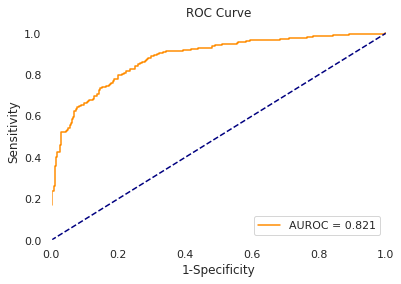

In [34]:
valid_fpr2 = valid_fpr[0]
valid_tpr2 = valid_tpr[0]

import matplotlib.pyplot as plt

%matplotlib inline 

fig, ax = plt.subplots()
ax.set_facecolor('white')  # Set the background color

plt.plot(valid_fpr2, valid_tpr2, color='darkorange', label=f"AUROC = {best_param['valid_roc']:.3f}")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title(f'ROC Curve')
plt.legend(loc="lower right", facecolor = 'white')

plt.savefig('AUROC.png', facecolor = 'white')
plt.show()



## Loss function 그래프

In [42]:
def moving_average(data, window_size=5):
    """Calculate the moving average of given data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 원하는 창의 크기를 설정
window_size = 5  
smooth_train_loss = moving_average(train_loss_vis2, window_size)
smooth_valid_loss = moving_average(valid_loss_vis2, window_size)


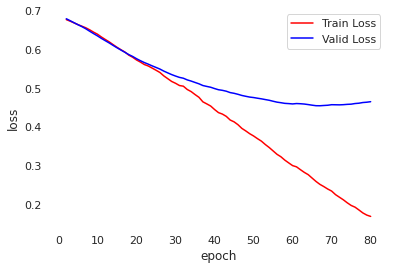

In [44]:
x_len_smooth = np.arange(len(smooth_train_loss)) + window_size // 2
fig, ax = plt.subplots()
ax.set_facecolor('white')  # Set the background color

plt.plot(x_len_smooth, smooth_train_loss, 'red', label='Train Loss')
plt.plot(x_len_smooth, smooth_valid_loss, 'blue', label='Valid Loss')

plt.legend(loc='upper right', facecolor = 'white')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('smooth_loss_function.png', facecolor = 'white')
plt.show()
